<a href="https://colab.research.google.com/github/paton838/works/blob/master/data-science/titanic/titanic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will analysis what factors will make an impact of the the Survival rate in the following steps:
- Preliminary analysis of the dataset
- Analyse the correlation between survival vs other factors

This analysis will help us to detemine what features should be selected/engineered for the machine learning model to make prediction on survival.

In [0]:
# Source: https://www.kaggle.com/c/titanic

In [0]:
import pandas as pd
import numpy as np
import re as re
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# read in the data
train = pd.read_csv("./train.csv")

In [0]:
# get the dataset for analysis
df = train

In [394]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are a lot of missing data in the Cabin column. 
If we use this as a feature for prediction, we will need to impute a lot of data into it, hence the prediction using this feature will not be very reliable.


In [395]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Number of Companions vs Survival**

Let's add a Companion column to indicate if the number of companions the person has.

In [396]:
df['Companion'] = df['SibSp'] + df['Parch']
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Companion
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [397]:
summ = df[['Companion', 'Survived']].groupby(['Companion'], as_index=False).agg(['mean', 'count'], as_index=False)
summ

Survived      
               mean count
Companion                
0          0.303538   537
1          0.552795   161
2          0.578431   102
3          0.724138    29
4          0.200000    15
5          0.136364    22
6          0.333333    12
7          0.000000     6
10         0.000000     7

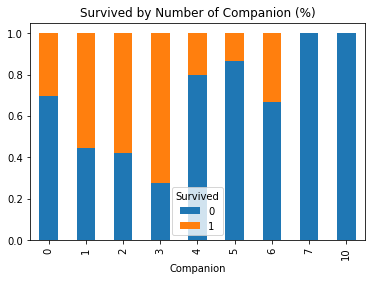

In [398]:
pd.crosstab(df['Companion'], df['Survived'], normalize='index') \
  .plot(kind='bar', stacked=True, title="Survived by Number of Companion (%)")

Most of the people in the subset of data recorded were alone (537 people), and the survival rate increases as the number of companion increases to up to 3, and decreases after having more than 3 companions.

This table also indicates that the people who have the highest survival chances (72%) have a family size of 3, which is a medium size family

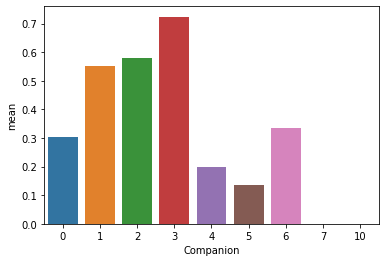

In [399]:
sns.barplot(x=summ.index, y=summ['Survived']['mean'])

The chart above shows that as the number of companions increases (but not more than 3), the chances of survival also increases. However, this trend does not follow the same pattern once the number of companions is more than 3.

This shows that the number of companions has a non-linear relationship with the survival rate.

**Ticket Class vs Survival**

In [400]:
df[['Pclass', 'Survived']].groupby(['Pclass']).agg(['mean', 'count'])

Survived      
            mean count
Pclass                
1       0.629630   216
2       0.472826   184
3       0.242363   491

This result suggests that higher the Ticket Class purchased, higher the survival rate. 

**Gender vs Survival**

In [401]:
df[['Sex', 'Survived']].groupby(['Sex']).agg(['mean', 'count'])

Survived      
            mean count
Sex                   
female  0.742038   314
male    0.188908   577

This result suggests that being a female on Titanic has a much higher survival rate! (74% vs 19%)

**Age vs Survival**

In [402]:
df.groupby(['Survived'])['Age'].mean()


Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

There is not much different in the average age between the survived and not survived people. 

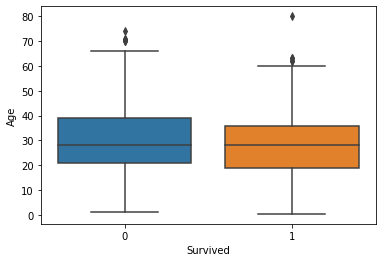

In [403]:
sns.boxplot(data=df, x='Survived', y='Age')

This plot suggests that the median age is about the same.

However, overall, the people who died tend to be older than the people who survived.

Now, let's look at the Age distribution between survived and not survived

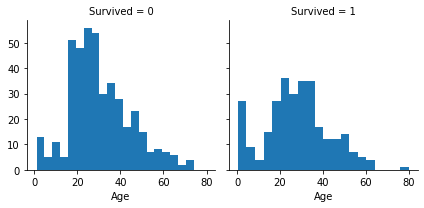

In [404]:
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

On the good side, there were a large number of infants survived. However, there were sadly a lot of young people (20-30 years old) who did not make it.

This result shows that higher in age does not always mean higher the survival rate, therefore, this is a non-linear relationship between Age and Survival

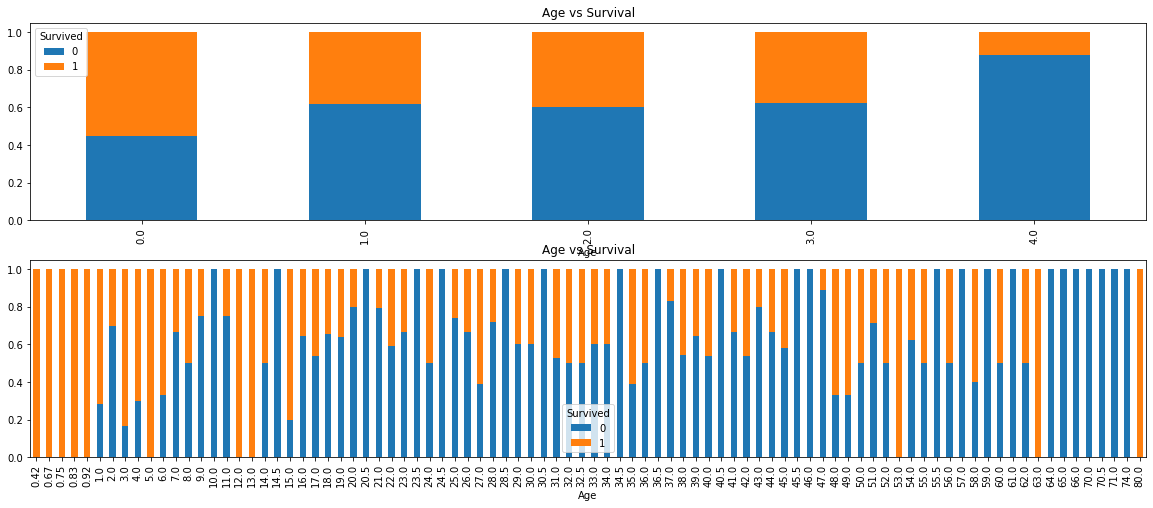

In [427]:
fig, (ax_age, ax_age_all) = plt.subplots(2, 1, figsize=(20,8))

df_age = df[['Age', 'Survived']].dropna();
df_age.loc[ df_age['Age'] <= 16, 'Age']                         = 0
df_age.loc[(df_age['Age'] > 16) & (df_age['Age'] <= 35), 'Age'] = 1
df_age.loc[(df_age['Age'] > 35) & (df_age['Age'] <= 50), 'Age'] = 2
df_age.loc[(df_age['Age'] > 50) & (df_age['Age'] <= 65), 'Age'] = 3
df_age.loc[ df_age['Age'] > 65, 'Age']                          = 4

df_age.groupby('Age')['Age'].count()

age_plot = pd.crosstab(df_age["Age"], df_age["Survived"], normalize='index')
age_plot.plot(kind='bar', stacked=True, title='Age vs Survival', ax=ax_age)

ax_age_all_plot = pd.crosstab(df["Age"], df["Survived"], normalize='index')
ax_age_all_plot.plot(kind='bar', stacked=True, title='Age vs Survival', ax=ax_age_all)

This result suggests that the infants were very likely to survive, and the chances remains high until 15 years of age. The chances goes down to about 40% for people between young to middle age, and it increases for people older than middle age (about 45 years old) and just before the old age (about 65 years old). The older people (above 65 years old) have the lowest survival rate.

**Fare vs Survival analysis**

Let's group the Fare into 4 different categories, with 0 being the lowest Fare paid, and 3 being the highest.

In [406]:
# Let's group the Fare in different categories
df.loc[ df['Fare'] <= 10, 'Fare']                           = 0
df.loc[(df['Fare'] > 10) & (df['Fare'] <= 20), 'Fare']      = 1
df.loc[(df['Fare'] > 20) & (df['Fare'] <= 30), 'Fare']      = 2
df.loc[ df['Fare'] > 30, 'Fare']                            = 3

df2 = df[['Survived', 'Fare']]
df2.groupby(['Fare'])['Survived'].agg(['mean', 'count'])

,mean,count
Fare,,
0.0,0.199405,336
1.0,0.424581,179
2.0,0.443662,142
3.0,0.581197,234


This result suggests higher the Fare paid, higher the survival rate, which is sad but makes sense.

**Embarked vs Survival**

![alt text](https://ipfactly.com/wp-content/uploads/2018/07/14a-titanic_voyage_map.jpeg?31623f)

1st port:
S: Southampton

2nd port:
C: Cherbourg

3rd port:
Q: Queenstown


In [407]:
df[['Survived', 'Embarked']].groupby(['Embarked']).agg(['mean', 'count'])

Survived      
              mean count
Embarked                
C         0.553571   168
Q         0.389610    77
S         0.336957   644

This result shows that most people from the dataset got on-board from Southampton, and they have the lowest survival rate (34%) but not too much different to Queenstown's passengers (39%). The people who got on from Cherbourg have the highest survival rate (55%). 

This is interesting - is it suggesting that the Southampton people (1st port) were more likely to be pushed to stay in the inner cabin, which reduced their chances to escape? Or if there were other reasons for this result?
Let's find it out:

In [0]:
# label the gender to a number to calculate the male/female ratio later
df['Sex'] = df['Sex'].replace('female', 0)
df['Sex'] = df['Sex'].replace('male', 1)

Compare the other factors associated with the Embarked ports.
- Sex
- Fare
- Companion
- Age
- Pclass

In [409]:
summ = df[['Sex', 'Fare', 'Companion', 'Pclass', 'Embarked']] \
        .groupby(['Embarked']) \
        .agg(['mean', 'count'])
summ

Sex            Fare       Companion          Pclass      
              mean count      mean count      mean count      mean count
Embarked                                                                
C         0.565476   168  1.845238   168  0.750000   168  1.886905   168
Q         0.532468    77  0.480519    77  0.597403    77  2.909091    77
S         0.684783   644  1.260870   644  0.984472   644  2.350932   644

Text(0, 0.5, 'Mean - Male Ratio')

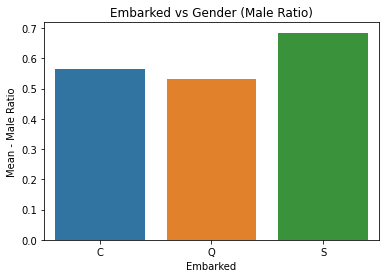

In [410]:
sns.barplot(x=summ.index, y=summ['Sex']['mean'])
plt.title('Embarked vs Gender (Male Ratio)')
plt.ylabel('Mean - Male Ratio')

This result shows that the people who embarked from Southampton has the highest male ratio (68% males), while Queenstown has the lowest male ratio (53% males). Cherbourg has a male ratio of 57%.

Text(0, 0.5, 'Mean - Fare Categories')

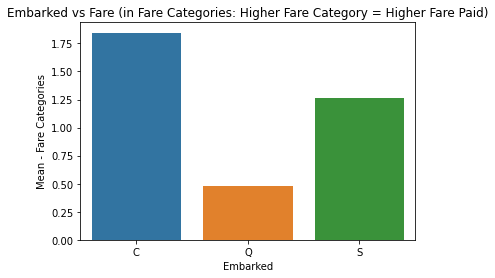

In [411]:
sns.barplot(x=summ.index, y=summ['Fare']['mean'])
plt.title('Embarked vs Fare (in Fare Categories: Higher Fare Category = Higher Fare Paid)')
plt.ylabel('Mean - Fare Categories')

The chart above suggests that the Cherbourg people have generally paid for much higher fares, while the Queenstown have paid for the lowest fare  on average.

**Different Embarked - Number of Companion vs Survival**

How did the number of companion affact the survival rate for different embarking ports?

Firstly, we will group the data in 3 Embarked ports:

In [0]:
c_companion = df.loc[df['Embarked']=='C']
q_companion = df.loc[df['Embarked']=='Q']
s_companion = df.loc[df['Embarked']=='S']

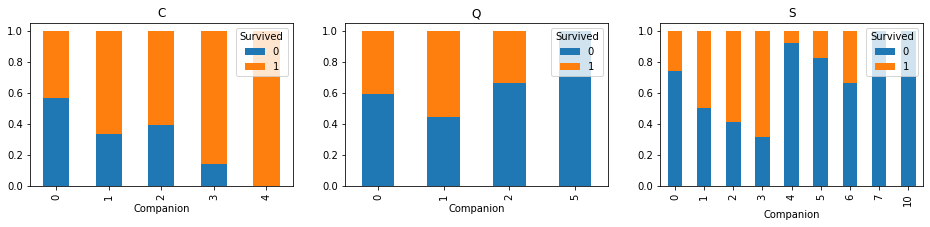

In [413]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,3))

a1 = pd.crosstab(c_companion["Companion"], c_companion["Survived"], normalize='index')
a1.plot(kind='bar', stacked=True, title='C', ax=ax1)

a2 = pd.crosstab(q_companion["Companion"], q_companion["Survived"], normalize='index')
a2.plot(kind='bar', stacked=True, title='Q', ax=ax2)

a3 = pd.crosstab(s_companion["Companion"], s_companion["Survived"], normalize='index')
a3.plot(kind='bar', stacked=True, title='S', ax=ax3)

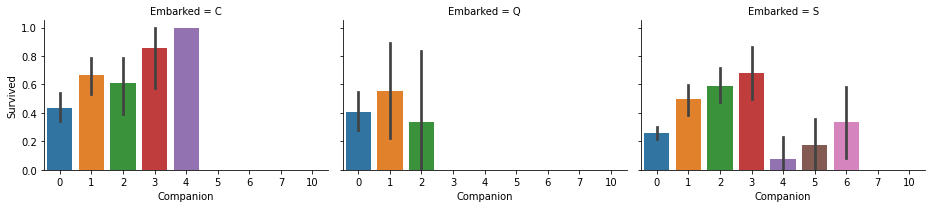

In [414]:
g = sns.catplot(x="Companion", y="Survived", col='Embarked', data=df, 
                kind="bar", height=3, aspect=1.45, col_order=['C','Q','S']);

These charts suggests that there were some large families embarked from Southampton, while the family size of the people embarked from Queenstown and Cherbourg were much smaller.

**Ticket Class vs Survival**

Text(0, 0.5, 'Mean - Ticket Class')

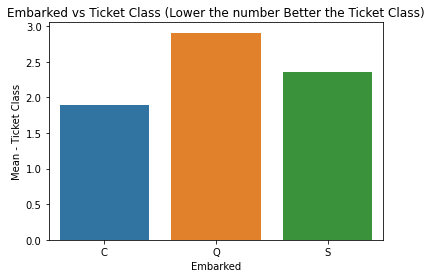

In [415]:
sns.barplot(x=summ.index, y=summ['Pclass']['mean'])
plt.title('Embarked vs Ticket Class (Lower the number Better the Ticket Class)')
plt.ylabel('Mean - Ticket Class')

Clearly, the Cherbourg people have generally paid for the best ticket class, while the Queenstown people on average have bought the worst ticket class.

**Embarked - Summary**


This result suggests that the people embarked from Cherbourg were more likely to survive was because there were more females, the family size were small to medium, and they have generally paid for more expensive tickets. 

**Status vs Survival**

Let's explore the Names to see if the person has a special title or higher status resulted in higher survival rate:

In [416]:
# =====================
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

df['Title'] = df['Name'].apply(get_title)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Companion,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0.0,NaN,S,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,3.0,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,0.0,NaN,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.0,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,0.0,NaN,S,0,Mr


In [0]:
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [418]:
df.groupby(['Title'])['Survived'].agg(['mean', 'count'], result_type='expand').sort_values(by='mean', ascending=False)

,mean,count
Title,,
Mrs,0.793651,126
Miss,0.702703,185
Master,0.575000,40
Rare,0.347826,23
Mr,0.156673,517


THis result suggests that the ladies (especially the married ones) have a much higher survival rate, followed by Master, and people with rare titles. 

The average men (Mr) were the majority of the people in the dataset (517 people), and have the lowest survival rate.

Again, it's sad but it makes sense...

**Heatmap to show correlation between Survival and other factors**

In [419]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Companion,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0.0,NaN,S,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,3.0,C85,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,0.0,NaN,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.0,C123,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,0.0,NaN,S,0,Mr


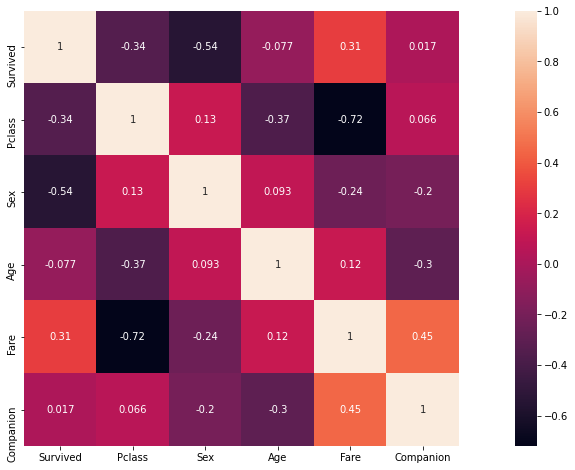

In [420]:
plt.figure(figsize=(20,8))

f = (
	df.loc[:, ['Survived','Pclass','Sex','Age','Fare','Companion','Title']]
	# .dropna()
).corr()
sns.heatmap(f, annot=True, robust=True, square=True)

As expected: 
  - Against the Survival rate
    - Pclass has a negative relationship, meaning lower the Pclass number (higher class), higher the survival rate
    - Sex has a negative relationship, meaning the females (with label: 0) has a higher survival rate
    - Fare has a positive relationship 
    - Although the Age and the Companion do not show a strong relationship in the heatmap, it does not mean there is not relationship.
      - As discussed above, the relationship with survival rate of these two seems to be non-linear, 
      - as the people in the middle (not too young or too old, medium size family) have a higher survival rate.

**Summary**

- The infants were most likely to survive, followed by the young people (less than 15 years old), then the people after the middle age and just before the old age (about 46 to 65 years old - possibly with higher status and more wealth), and then the young and/or adults (about 16 to 45 years old). The old people (more than about 66 years old) have the lowest survival rate.
- The people who have purchased the more expensive tickets have a much higher chance to survive than the ones who bought cheaper tickets.
- Females (especially the married ones) have the highest survival rate, followed by the people with special titles (possibly higher status). The Mr. have the lowest survival rate.
- The people with a small to medium sized family was more likely to survive than the ones with a large family (with a total number of companions of more than 3).
- The people embarked from Cherbourg have the highest survival rate, followed by Queenstown, Southampton.